In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from nilearn import datasets, maskers
from nilearn.image import resample_img
import nibabel as nib

from neuroquery.datasets import fetch_neuroquery_model
from neurovlm.data import get_data_dir
from neurovlm.train import which_device
from neurovlm.loss import compute_metrics

device = which_device()

### difumo embeddings

In [ ]:
# NeuroVLM embeddings
neurovlm_dir = get_data_dir()
neuro_vectors = torch.load(neurovlm_dir / "neuro_vectors.pt")

# Get test split used, held out from autoencoder training
inds = np.arange(len(neuro_vectors))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)
neuro_vectors = neuro_vectors.cpu().detach()

# Load mask
data_dir = get_data_dir()
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()

# Load difumo
difumo = datasets.fetch_atlas_difumo(
    dimension=512,
    resolution_mm=2,
    legacy_format=False,
)
difumo_masker = maskers.NiftiMapsMasker(maps_img=difumo.maps)
difumo_masker.fit()

In [ ]:
# Embed - slow
batch_size = 32

for method in ["cont", "bin"]:

    if method == "bin":
        neuro_vectors[neuro_vectors > 0.001] = 1.0
        neuro_vectors[neuro_vectors <= 0.001] = 0.0

    difumo_vecs = np.zeros((len(test_inds), 512))

    for i in tqdm(range(0, len(test_inds), batch_size), total=len(test_inds)//batch_size):
        img = masker.inverse_transform(neuro_vectors[test_inds[i:i+batch_size]])
        difumo_vecs[i:i+batch_size] = difumo_masker.transform(img) # shape (512,)

    np.save(data_dir / f"difumo_embeddings_{method}.npy", difumo_vecs)

In [ ]:
# Inverse and resample - also slow
batch_size = 32

for method in ["cont", "bin"]:

    difumo_vecs = np.load(data_dir / f"difumo_embeddings_{method}.npy")
    difumo_vecs_resampled = np.zeros((len(difumo_vecs), 28542))

    for i in tqdm(range(0, len(difumo_vecs), batch_size), total=len(difumo_vecs)//batch_size):
        img = difumo_masker.inverse_transform(difumo_vecs[i:i+batch_size])
        difumo_vecs_resampled[i:i+batch_size] = masker.transform(img)

    np.save(data_dir / f"difumo_embeddings_resampled_{method}.npy", difumo_vecs_resampled)

In [3]:
# load autoencoder
data_dir = get_data_dir()
autoencoder = torch.load(data_dir / "autoencoder.pt", weights_only=False)

# filter neurovlm neurovectors
neuro_vectors = torch.load(data_dir / "neuro_vectors.pt")
neuro_vectors = neuro_vectors[test_inds]
neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.
neuro_vectors_bin[neuro_vectors_bin <= 0.001] = 0.

In [4]:
# autoencoder
y_pred_ae = torch.sigmoid(autoencoder(neuro_vectors.to(device)).detach().cpu()).numpy()
y_pred_ae_bin = torch.sigmoid(autoencoder(neuro_vectors_bin.to(device)).detach().cpu()).numpy()

# load difumo
y_pred_di = np.load(data_dir / f"difumo_embeddings_resampled_cont.npy")
y_pred_di_bin = np.load(data_dir / f"difumo_embeddings_resampled_bin.npy")

# mask
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
masker_4mm = maskers.NiftiMasker(
    mask_img=nib.Nifti1Image(mask_arrays["mask"].astype(float), mask_arrays["affine"]),
    dtype=np.float32
).fit()

# tensors to arrays
neuro_vectors_np = neuro_vectors.numpy()
neuro_vectors_bin_np = neuro_vectors_bin.numpy()

In [ ]:
results = {}
thresholds = np.linspace(0, 1, 21)[:-1] * 100
target = "bin"
logloss_fn = nn.CrossEntropyLoss()

for target in ["binary", "continuous"]:
    results[target] = {}
    for method in ["di", "ae"]:
        results[target][method] = {}
        for embedding in ["binary", "continuous"]:

            if method == "ae" and embedding == "continuous":
                # expects binary embedding
                continue

            # metrics
            mse = np.zeros((len(test_inds), len(thresholds)))
            dice = np.zeros((len(test_inds), len(thresholds)))
            ssim = np.zeros((len(test_inds), len(thresholds)))
            r = np.zeros(len(test_inds))
            logloss = np.zeros(len(test_inds))

            for i in tqdm(range(len(test_inds)), total=len(test_inds)):

                # select true
                if target == "binary":
                    nvecs = neuro_vectors_bin_np[i]
                elif target == "continuous":
                    nvecs = neuro_vectors_np[i]
                else:
                    raise ValueError

                # select predicted
                if method == "di" and embedding == "binary":
                    y_pred = y_pred_di_bin[i]
                elif method == "di" and embedding == "continuous":
                    y_pred = y_pred_di[i]
                elif method == "ae" and embedding == "binary":
                    y_pred = y_pred_ae_bin[i]
                else:
                    raise ValueError
                # elif method == "ae" and embedding == "continuous":
                #     y_pred = y_pred_ae[i]

                # metrics
                mse[i], dice[i], ssim[i] = compute_metrics(
                    nvecs, y_pred, thresholds=thresholds, percentile=True
                )
                r[i] = np.corrcoef(nvecs, y_pred)[0][1]
                logloss[i] = logloss_fn(torch.from_numpy(y_pred),
                                        torch.from_numpy(nvecs))
                results[target][method][embedding] = {
                    "mse": mse,
                    "dice": dice,
                    "ssim": ssim,
                    "r": r,
                    "logloss": logloss
                }

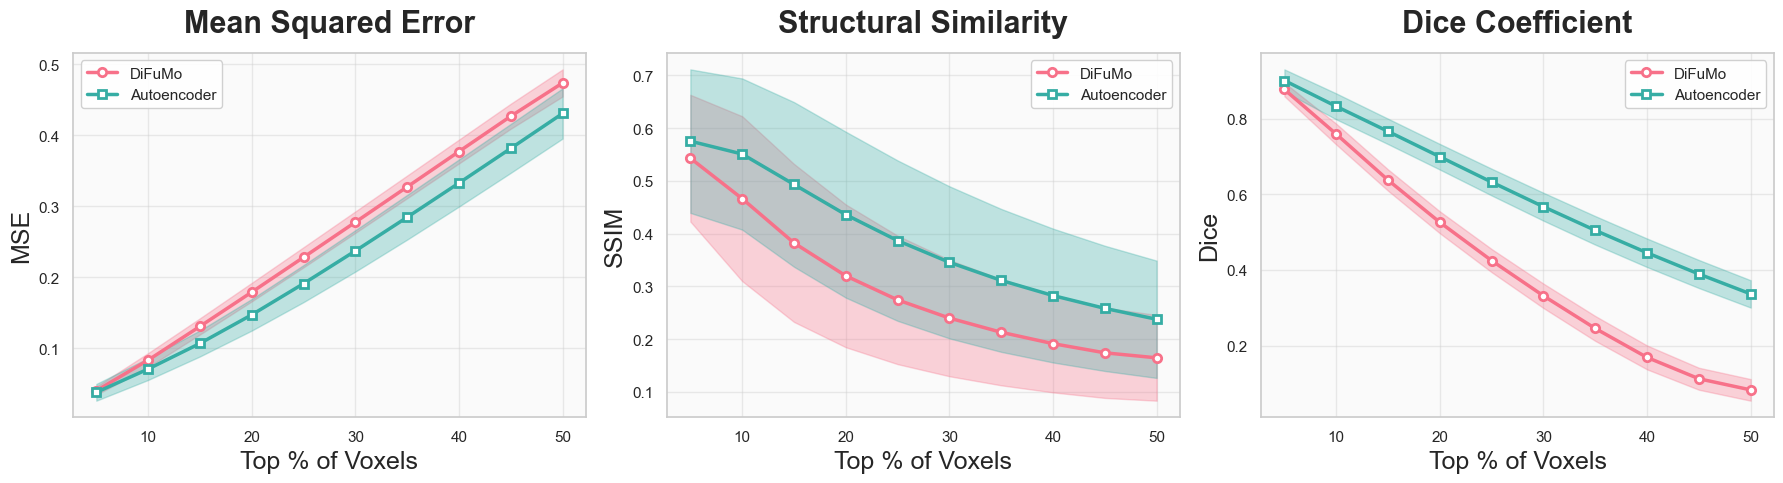

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern seaborn style for nice plots
sns.set_style("whitegrid")
sns.set_context("notebook")
colors = sns.color_palette("husl", 2)

thresholds = np.linspace(0, 1, 21)[:-1] * 100
mask = (thresholds >= 50)
sparse_mask = neuro_vectors.sum(axis=1)
sparse_mask = sparse_mask < np.percentile(sparse_mask, 50)

# Helper function to compute mean/std
def summarize(arr):
    return arr.mean(axis=0), arr.std(axis=0)

# Summarize metrics
results_di = results["continuous"]["di"]
results_ae = results["continuous"]["ae"]

method_di = 'continuous'
method_ae = 'binary' # use the version of the autoencoder trained on binarized targets

mse_di_mean, mse_di_std = summarize(results_di[method_di]["mse"][sparse_mask])
mse_ae_mean, mse_ae_std = summarize(results_ae[method_ae]["mse"][sparse_mask])
ssim_di_mean, ssim_di_std = summarize(results_di[method_di]["ssim"][sparse_mask])
ssim_ae_mean, ssim_ae_std = summarize(results_ae[method_ae]["ssim"][sparse_mask])
dice_di_mean, dice_di_std = summarize(results_di[method_di]["dice"][sparse_mask])
dice_ae_mean, dice_ae_std = summarize(results_ae[method_ae]["dice"][sparse_mask])

r_di_flat = results_di[method_di]["r"]
r_ae_flat = results_ae[method_ae]["r"]
r_di_flat[np.isnan(r_di_flat)] = 0.
r_ae_flat[np.isnan(r_ae_flat)] = 0.

# Create horizontal subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Styled function to plot mean/std curves
def plot_metric(ax, thresholds, di_mean, di_std, ae_mean, ae_std, title, ylabel):

    # Plot lines with markers
    ax.plot(100-thresholds[mask], di_mean[mask], label="DiFuMo", color=colors[0],
            linewidth=2.5, marker='o', markersize=6, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors[0])
    ax.fill_between(100-thresholds[mask], (di_mean - di_std)[mask], (di_mean + di_std)[mask],
                    alpha=0.3, color=colors[0])

    ax.plot(100-thresholds[mask], ae_mean[mask], label="Autoencoder", color=colors[1],
            linewidth=2.5, marker='s', markersize=6, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors[1])
    ax.fill_between(100-thresholds[mask], (ae_mean - ae_std)[mask], (ae_mean + ae_std)[mask],
                    alpha=0.3, color=colors[1])

    # Styling
    ax.set_title(f'{title}', fontsize=22, fontweight='bold', pad=15)
    ax.set_xlabel('Top % of Voxels', fontsize=18, fontweight='medium')
    ax.set_ylabel(ylabel, fontsize=18, fontweight='medium')
    ax.legend(frameon=True, fancybox=True, shadow=False, framealpha=0.9)
    ax.grid(True, alpha=0.4)
    ax.set_xticks(100-np.arange(50, 91, 10))
    ax.set_facecolor('#fafafa')

# Plot first three metrics with line + shaded std
plot_metric(axes[0], thresholds, mse_di_mean, mse_di_std, mse_ae_mean, mse_ae_std,
            "Mean Squared Error", "MSE")
plot_metric(axes[1], thresholds, ssim_di_mean, ssim_di_std, ssim_ae_mean, ssim_ae_std,
            "Structural Similarity", "SSIM")
plot_metric(axes[2], thresholds, dice_di_mean, dice_di_std, dice_ae_mean, dice_ae_std,
           "Dice Coefficient", "Dice")

plt.tight_layout()
plt.savefig(get_data_dir() / "autoencoder_vs_difumo_sparse.png")